In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Lambda,Compose,Resize,Normalize
import matplotlib.pyplot as plt
from functools import reduce
from models.equivariant import *
from groupconv.groups import *
from utils.train import count_params, train,val
from data.loader import get_loader
import os

In [2]:
torch.manual_seed(1)

In [3]:
BS=1
EPOCHS=15
NCLASSES = 10
NAME = "C4SimpleCNNSigmoid_FashionMNIST"

Get a random sample from the testset

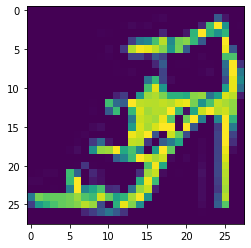

True label:tensor([5])


In [4]:
testloader = get_loader("test",BS,NCLASSES)
it = iter(testloader)
x,y = next(it)
plt.imshow(x[0,0,:,:])
plt.show()
label = torch.argmax(y,dim=-1)
print(f"True label:{label}")

Apply a 90 degree rotation to the sample of the set

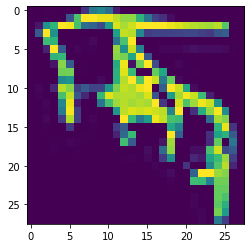

In [5]:
x_rot = torch.rot90(x,dims=[-2,-1])
plt.imshow(x_rot[0,0,:,:])
plt.show()

Instantiate the Group Equivariant Convolutional Network trained on the dataset without augmentation

In [6]:
m = EqSimpleCNNSigmoid(CyclicGroup(4),4,NCLASSES)
m.eval()
print(m)

EqSimpleCNNSigmoid(
  (c1): LiftingConvolution(
    (kernel): InterpolativeLiftingKernel(
      (group): CyclicGroup()
    )
  )
  (r1): Sigmoid()
  (p1): SpatialMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): GroupConvolution(
    (kernel): InterpolativeGroupKernel(
      (group): CyclicGroup()
    )
  )
  (r2): Sigmoid()
  (p2): SpatialMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): GroupConvolution(
    (kernel): InterpolativeGroupKernel(
      (group): CyclicGroup()
    )
  )
  (r3): Sigmoid()
  (gp): GlobalMaxPooling()
  (group_pooling): GroupMaxPool()
  (clf): Linear(in_features=128, out_features=10, bias=True)
)


/home/giorgio/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
ret = m.load_state_dict(torch.load(f"ckpt/{NAME}.pth"))
ret

<All keys matched successfully>

Compute the feature maps for all intermediate layers for both the sample both for the 0 rotation and the 90 degree rotation

In [8]:
oc1 = m.c1(x)
or1 = m.r1(oc1)
op1 = m.p1(or1)
oc2 = m.c2(op1)
or2 = m.r2(oc2)
op2 = m.p2(or2)
oc3 = m.c3(op2)
or3 = m.r3(oc3)
ogp = m.gp(or3)
ogrp = m.group_pooling(ogp)
oclf = m.clf(ogrp)

In [9]:
oc1_rot = m.c1(x_rot)
or1_rot = m.r1(oc1_rot)
op1_rot = m.p1(or1_rot)
oc2_rot = m.c2(op1_rot)
or2_rot = m.r2(oc2_rot)
op2_rot = m.p2(or2_rot)
oc3_rot = m.c3(op2_rot)
or3_rot = m.r3(oc3_rot)
ogp_rot = m.gp(or3_rot)
ogrp_rot = m.group_pooling(ogp_rot)
oclf_rot = m.clf(ogrp_rot)

In [10]:
feature_maps = [oc1,or1,op1,oc2,or2,op2,oc3,or3,ogp,ogrp,oclf]
feature_maps_rot = [oc1_rot,or1_rot,op1_rot,oc2_rot,or2_rot,op2_rot,oc3_rot,or3_rot,ogp_rot,ogrp_rot,oclf_rot]

Show the output feature map from layer "layer_idx". In the first row the feature maps of the 0 degree rotated sample, and in the second row the feature maps of the 90 degree rotated sample. We can se that they are the same features, shifted on the group dimension and rotated on the spatial dimension.

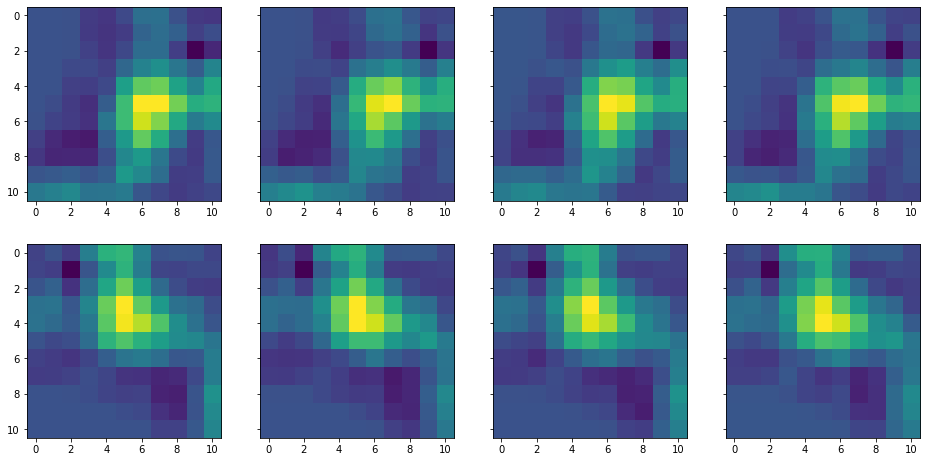

In [11]:
layer_idx = 3       # [0,8]
filter_idx = 0      # the range depends on the layer
fig,ax = plt.subplots(2,4,sharey=True)
fig.set_size_inches(16,8)
for g in range(4):
    f = feature_maps[layer_idx][0,filter_idx,g,...]
    f_rot = feature_maps_rot[layer_idx][0,filter_idx,g,...]
    if len(f.shape)<2:
        ax[0,g].scatter(0,f.detach().numpy())
        ax[1,g].scatter(0,f_rot.detach().numpy())
    else:
        ax[0,g].imshow(f.detach().numpy())
        ax[1,g].imshow(f_rot.detach().numpy())
plt.show()

This is still more evident if we take the feature maps of the rotated sample and rotate them by 270 degree and shift them by one on the group dimension. The first row shows the feature maps of the 0 degree rotated sample, the second row shows the feature maps of the 90 degree rotated sample (rotated by 270 degree and shifted by one)

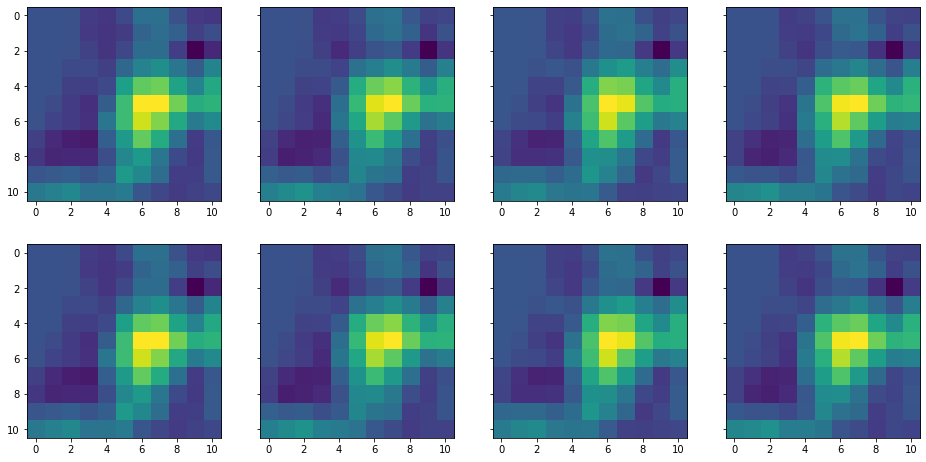

In [12]:
fig,ax = plt.subplots(2,4,sharey=True)
fig.set_size_inches(16,8)
for g in range(4):
    f = feature_maps[layer_idx][0,filter_idx,g,...]
    f_rot = feature_maps_rot[layer_idx][0,filter_idx,(g+1)%4,...]
    if len(f.shape)>=2:
        f_rot = torch.rot90(f_rot,3)
    if len(f.shape)<2:
        ax[0,g].scatter(0,f.detach().numpy())
        ax[1,g].scatter(0,f_rot.detach().numpy())
    else:
        ax[0,g].imshow(f.detach().numpy())
        ax[1,g].imshow(f_rot.detach().numpy())
plt.show()

This Figure shows the latent representation of the two layers (the feature map before the classification layer), in which the group dimension has been reduced with an operation that does not depend on the order (max). 
This representation should be invariant to the actions of the group on the input image. Indeed we can see that the two latent vectors are very similar. The first line represents the latent representation of the 0 degree rotated sample. The second line the latent representation of the 90 degree rotated sample, while the third row shows their l1 distance (element-wise)

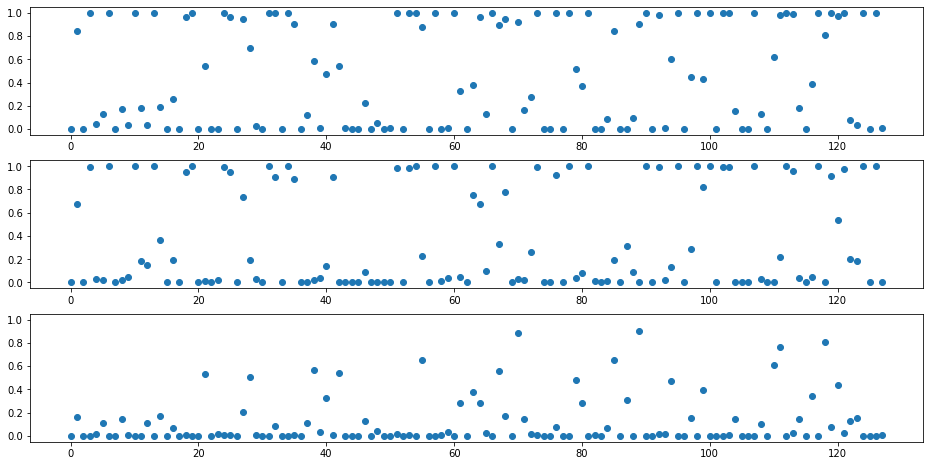

In [13]:
fig,ax = plt.subplots(3,1,sharey=True)
fig.set_size_inches(16,8)
ax[0].scatter(np.arange(128),ogrp[0].detach().numpy())
ax[1].scatter(np.arange(128),ogrp_rot[0].detach().numpy())
ax[2].scatter(np.arange(128),torch.abs(ogrp[0]-ogrp_rot[0]).detach().numpy())
plt.show()